In [1]:
pip install fuzzy-c-means

Note: you may need to restart the kernel to use updated packages.


In [2]:
## This algorithm works by assigning membership to each data point corresponding to each cluster center on the 
#  basis of distance between the cluster center and the data point. More the data is near to the cluster center
#  more is its membership towards the particular cluster center.

import pandas as pd
import numpy as np
import random
import operator
import math

from fcmeans import FCM
from sklearn.datasets import make_blobs
from matplotlib import pyplot as plt
from seaborn import scatterplot as scatter

In [3]:
# Importing the covid_india dataset by pandas
df_full = pd.read_csv(r'C:\Users\DELL\Desktop\dsa project\covid_19_india.csv')

df=df_full.groupby(['State/UnionTerritory']).agg({'Cured':'mean','Deaths':'mean','Confirmed':'mean'})
df.size
df.head()


,Cured,Deaths,Confirmed
State/UnionTerritory,,,
Andaman and Nicobar Islands,791.078125,12.953125,992.109375
Andhra Pradesh,112389.616505,1303.854369,144683.936893
Arunachal Pradesh,1233.298913,3.211957,1807.875000
Assam,32840.709677,130.284946,42665.365591
Bihar,39399.836735,241.668367,47596.515306


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 39 entries, Andaman and Nicobar Islands to West Bengal
Data columns (total 3 columns):
Cured        39 non-null float64
Deaths       39 non-null float64
Confirmed    39 non-null float64
dtypes: float64(3)
memory usage: 1.2+ KB


In [5]:
# Number of Attributes
num_attr = len(df.columns) - 1

# Number of Clusters to make
k = 3

# Maximum number of iterations
MAX_ITER = 100

# Number of data points
n = len(df)

# Fuzzy parameter
m = 2.00

In [6]:
#Utility Function for Evaluating the Result
#### accuracy function for measuring the accuracy of our result

def accuracy(cluster_labels, class_labels):
    county = [0,0]
    countn = [0,0]
    tp = [0, 0]
    tn = [0, 0]
    fp = [0, 0]
    fn = [0, 0]
    
    for i in range(len(df)):
        # Yes = 1, No = 0
        if cluster_labels[i] == 1 and class_labels[i] == 'Yes':
            tp[0] = tp[0] + 1
        if cluster_labels[i] == 0 and class_labels[i] == 'No':
            tn[0] = tn[0] + 1
        if cluster_labels[i] == 1 and class_labels[i] == 'No':
            fp[0] = fp[0] + 1
        if cluster_labels[i] == 0 and class_labels[i] == 'Yes':
            fn[0] = fn[0] + 1
    
    for i in range(len(df)):
        # Yes = 0, No = 1
        if cluster_labels[i] == 0 and class_labels[i] == 'Yes':
            tp[1] = tp[1] + 1
        if cluster_labels[i] == 1 and class_labels[i] == 'No':
            tn[1] = tn[1] + 1
        if cluster_labels[i] == 0 and class_labels[i] == 'No':
            fp[1] = fp[1] + 1
        if cluster_labels[i] == 1 and class_labels[i] == 'Yes':
            fn[1] = fn[1] + 1
    a0 = float((tp[0] + tn[0]))/float((tp[0] + tn[0] + fn[0] + fp[0]))
    a1 = float((tp[1] + tn[1]))/float((tp[1] + tn[1] + fn[1] + fp[1]))
    p0 = float(tp[0])/(tp[0] + fp[0])
    p1 = float(tp[1])/(tp[1] + fp[1])
    r0 = float(tp[0])/(tp[0] + fn[0])
    r1 = float(tp[1])/(tp[1] + fn[1])
    
    accuracy = [a0*100,a1*100]
    precision = [p0*100,p1*100]
    recall = [r0*100,r1*100]
    
    return accuracy, precision, recall

In [7]:
#Fuzzy C-means Algorithm
### STEP 1: initializing the membership matrix with random values

def initializeMembershipMatrix():
    membership_mat = list()
    for i in range(n):
        random_num_list = [random.random() for i in range(k)]
        summation = sum(random_num_list)
        temp_list = [x/summation for x in random_num_list]
        membership_mat.append(temp_list)
    return membership_mat

In [8]:
### STEP 2: calculating the cluster center, is done in every iteration

def calculateClusterCenter(membership_mat):
    cluster_mem_val = list(zip(*membership_mat))
    cluster_centers = list()
    for j in range(k):
        x = list(cluster_mem_val[j])
        xraised = [e ** m for e in x]
        denominator = sum(xraised)
        temp_num = list()
        for i in range(n):
            data_point = list(df.iloc[i])
            prod = [xraised[i] * val for val in data_point]
            temp_num.append(prod)
        numerator = map(sum, zip(*temp_num))
        center = [z/denominator for z in numerator]
        cluster_centers.append(center)
    return cluster_centers


In [9]:
### STEP 3: updating the membership values using the cluster centers form step 2

def updateMembershipValue(membership_mat, cluster_centers):
    p = float(2/(m-1))
    for i in range(n):
        x = list(df.iloc[i])
        distances = [np.linalg.norm(list(map(operator.sub, x, cluster_centers[j]))) for j in range(k)]
        for j in range(k):
            den = sum([math.pow(float(distances[j]/distances[c]), p) for c in range(k)])
            membership_mat[i][j] = float(1/den)       
    return membership_mat

In [10]:
#Function defined which returns the Clusters from the Membership Matrix

def getClusters(membership_mat):
    cluster_labels = list()
    for i in range(n):
        max_val, idx = max((val, idx) for (idx, val) in enumerate(membership_mat[i]))
        cluster_labels.append(idx)
    return cluster_labels

In [11]:
### the final fcm function, 
#Calling fcm function which runs for MAX_ITER number of times and returns the Result
#Repeat the steps until the constant values are obtained for the membership values or the difference is less than the 
#tolerance value 

def fuzzyCMeansClustering():
    # Membership Matrix
    membership_mat = initializeMembershipMatrix()
    curr = 0
    while curr <= MAX_ITER:
        cluster_centers = calculateClusterCenter(membership_mat)
        membership_mat = updateMembershipValue(membership_mat, cluster_centers)
        cluster_labels = getClusters(membership_mat)
        curr += 1
    
    print(membership_mat)
    return cluster_labels, cluster_centers

In [12]:
#Displaying the Results
#Outputting Cluster Labels and Cluster Centers

### calling the main function and storing the final results in labels, centers

print("printing the final membership matrix")

labels, centers = fuzzyCMeansClustering()

print("printing cluster centers")
print(centers)

printing the final membership matrix
[[0.011001869966299822, 0.9875907358440449, 0.0014073941896553112], [0.9071094688982276, 0.05693761553096594, 0.035952915570806494], [0.00981796285848957, 0.9889366018806227, 0.0012454352608876464], [0.15558868858362565, 0.8340548538176442, 0.01035645759873002], [0.2448645081188647, 0.7410027617035794, 0.01413273017755596], [0.007515642066062805, 0.9915505102138963, 0.0009338477200410324], [0.009584040903797084, 0.9892022859517389, 0.0012136731444638853], [0.0005854894491913444, 0.9993513903587095, 6.312019209923481e-05], [0.012706961122703437, 0.9856486488072426, 0.0016443900700540829], [0.010188972619616118, 0.9885151617919022, 0.0012958655884817126], [0.012710650610109765, 0.9856444433901049, 0.0016449059997853499], [0.8495492075221917, 0.13717461907028827, 0.013276173407520181], [0.00311509539010325, 0.9965133820026424, 0.0003715226072543986], [0.17750055417035027, 0.8111089604958909, 0.01139048533375873], [0.028847247035405765, 0.96858941192263

In [15]:
n_samples = 39
n_bins = 3  # use 3 bins for calibration_curve as we have 3 clusters here
centers = centers


In [24]:
X=df.iloc[:, [0,1, 2]]
X.head()

,Cured,Deaths,Confirmed
State/UnionTerritory,,,
Andaman and Nicobar Islands,791.078125,12.953125,992.109375
Andhra Pradesh,112389.616505,1303.854369,144683.936893
Arunachal Pradesh,1233.298913,3.211957,1807.875000
Assam,32840.709677,130.284946,42665.365591
Bihar,39399.836735,241.668367,47596.515306


In [25]:
# fit the fuzzy-c-means
fcm = FCM(n_clusters=3)
fcm.fit(X)

In [26]:
# outputs
fcm_centers = fcm.centers
fcm_labels  = fcm.u.argmax(axis=1)
df['labels']=fcm_labels
df.head(n=39)

,Cured,Deaths,Confirmed,labels
State/UnionTerritory,,,,
Andaman and Nicobar Islands,791.078125,12.953125,992.109375,2
Andhra Pradesh,112389.616505,1303.854369,144683.936893,0
Arunachal Pradesh,1233.298913,3.211957,1807.875000,2
Assam,32840.709677,130.284946,42665.365591,2
Bihar,39399.836735,241.668367,47596.515306,2
Cases being reassigned to states,0.000000,0.000000,5759.416667,2
Chandigarh,1334.366834,25.316583,1964.643216,2
Chhattisgarh,9567.336683,128.241206,15904.934673,2
Dadar Nagar Haveli,0.378378,0.000000,5.027027,2


In [30]:
fcm_labels

array([2, 0, 2, 2, 2, 2, 2, 2, 2, 2, 2, 0, 2, 2, 2, 2, 2, 2, 0, 2, 2, 2,
       1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 0, 2, 2, 2, 0, 2, 2], dtype=int64)

In [27]:
fcm_centers

,Cured,Deaths,Confirmed
0,86287.443138,1748.103758,111934.045683
1,221940.402926,10199.819038,324055.365951
2,9510.668698,169.409426,12930.348367


In [28]:
pd.Series(fcm_labels).value_counts()

2    33
0     5
1     1
dtype: int64

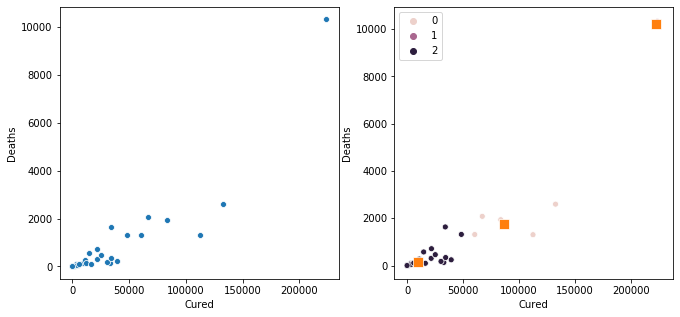

In [29]:
# plot result
%matplotlib inline
f, axes = plt.subplots(1, 2, figsize=(11,5))
scatter(X.iloc[:,0], X.iloc[:,1], ax=axes[0])
scatter(X.iloc[:,0], X.iloc[:,1], ax=axes[1], hue=fcm_labels)
scatter(fcm_centers.iloc[:,0], fcm_centers.iloc[:,1], ax=axes[1],marker="s",s=100)
plt.show()